In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import cv2
import os
import random
from PIL import Image
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [2]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Access the dataset
dataset_path = "/content/drive/MyDrive/4pestmy/Dataset"

In [4]:
# List the contents of the directory
import os
dataset_files = os.listdir(dataset_path)

# Print the list of files in the directory
print(dataset_files)

['train', 'test']


In [5]:
# Define paths to train and test folders
train_directory = os.path.join(dataset_path, "train")
test_directory = os.path.join(dataset_path, "test")


In [6]:
# Get a list of subfolders in the train folder
train_class = os.listdir(train_directory)
print("Classes in train folder:", train_class)

# Get a list of subfolders in the test folder
test_class = os.listdir(test_directory)
print("Classes in test folder:", test_class)

Classes in train folder: ['slug', 'weevil', 'Semilooper', 'sawfly', 'snail', 'stem_borer', 'Stem Girdler', 'Pod Borer', 'grasshopper', 'bollworm', 'mosquito', 'Mealybug', 'mites', 'bees', 'beetle', 'moth', 'mice', 'ants', 'aphids', 'armyworm']
Classes in test folder: ['weevil', 'Semilooper', 'snail', 'Stem Girdler', 'stem_borer', 'slug', 'mice', 'mosquito', 'moth', 'mites', 'grasshopper', 'sawfly', 'Pod Borer', 'Mealybug', 'ants', 'aphids', 'beetle', 'bollworm', 'bees', 'armyworm']


In [7]:
# Explore image counts per class
for class_name in train_class:
    train_class_dir = os.path.join(train_directory, class_name)
    test_class_dir = os.path.join(test_directory, class_name)

    num_train_images = len(os.listdir(train_class_dir))
    num_test_images = len(os.listdir(test_class_dir))

    print(f"Class '{class_name}': Train Images - {num_train_images}, Test Images - {num_test_images}")

Class 'slug': Train Images - 350, Test Images - 50
Class 'weevil': Train Images - 350, Test Images - 50
Class 'Semilooper': Train Images - 350, Test Images - 50
Class 'sawfly': Train Images - 350, Test Images - 50
Class 'snail': Train Images - 350, Test Images - 50
Class 'stem_borer': Train Images - 350, Test Images - 50
Class 'Stem Girdler': Train Images - 350, Test Images - 50
Class 'Pod Borer': Train Images - 350, Test Images - 50
Class 'grasshopper': Train Images - 350, Test Images - 50
Class 'bollworm': Train Images - 350, Test Images - 50
Class 'mosquito': Train Images - 350, Test Images - 50
Class 'Mealybug': Train Images - 350, Test Images - 50
Class 'mites': Train Images - 350, Test Images - 50
Class 'bees': Train Images - 350, Test Images - 50
Class 'beetle': Train Images - 350, Test Images - 50
Class 'moth': Train Images - 350, Test Images - 50
Class 'mice': Train Images - 350, Test Images - 50
Class 'ants': Train Images - 350, Test Images - 50
Class 'aphids': Train Images -

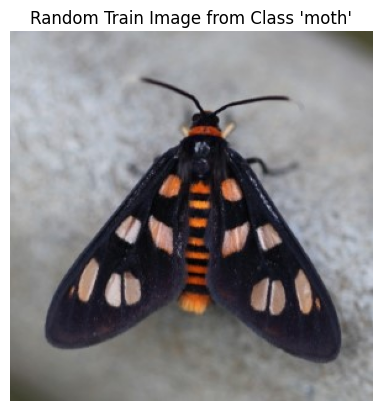

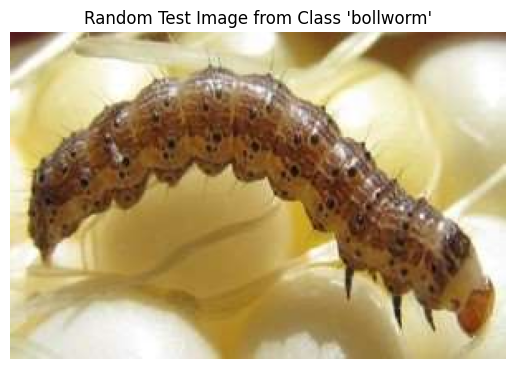

In [8]:
# Choose a random class from train and test datasets
random_train_class = random.choice(train_class)
random_test_class = random.choice(test_class)

# Define paths to random class directories in train and test datasets
random_train_class_dir = os.path.join(train_directory, random_train_class)
random_test_class_dir = os.path.join(test_directory, random_test_class)

# Get a list of image files in the random class directories
train_image_files = os.listdir(random_train_class_dir)
test_image_files = os.listdir(random_test_class_dir)

# Choose a random image from train and test datasets
random_train_image = random.choice(train_image_files)
random_test_image = random.choice(test_image_files)

# Define paths to random images in train and test datasets
random_train_image_path = os.path.join(random_train_class_dir, random_train_image)
random_test_image_path = os.path.join(random_test_class_dir, random_test_image)

# Load and display random train image
train_img = Image.open(random_train_image_path)
plt.imshow(train_img)
plt.title(f"Random Train Image from Class '{random_train_class}'")
plt.axis('off')
plt.show()

# Load and display random test image
test_img = Image.open(random_test_image_path)
plt.imshow(test_img)
plt.title(f"Random Test Image from Class '{random_test_class}'")
plt.axis('off')
plt.show()

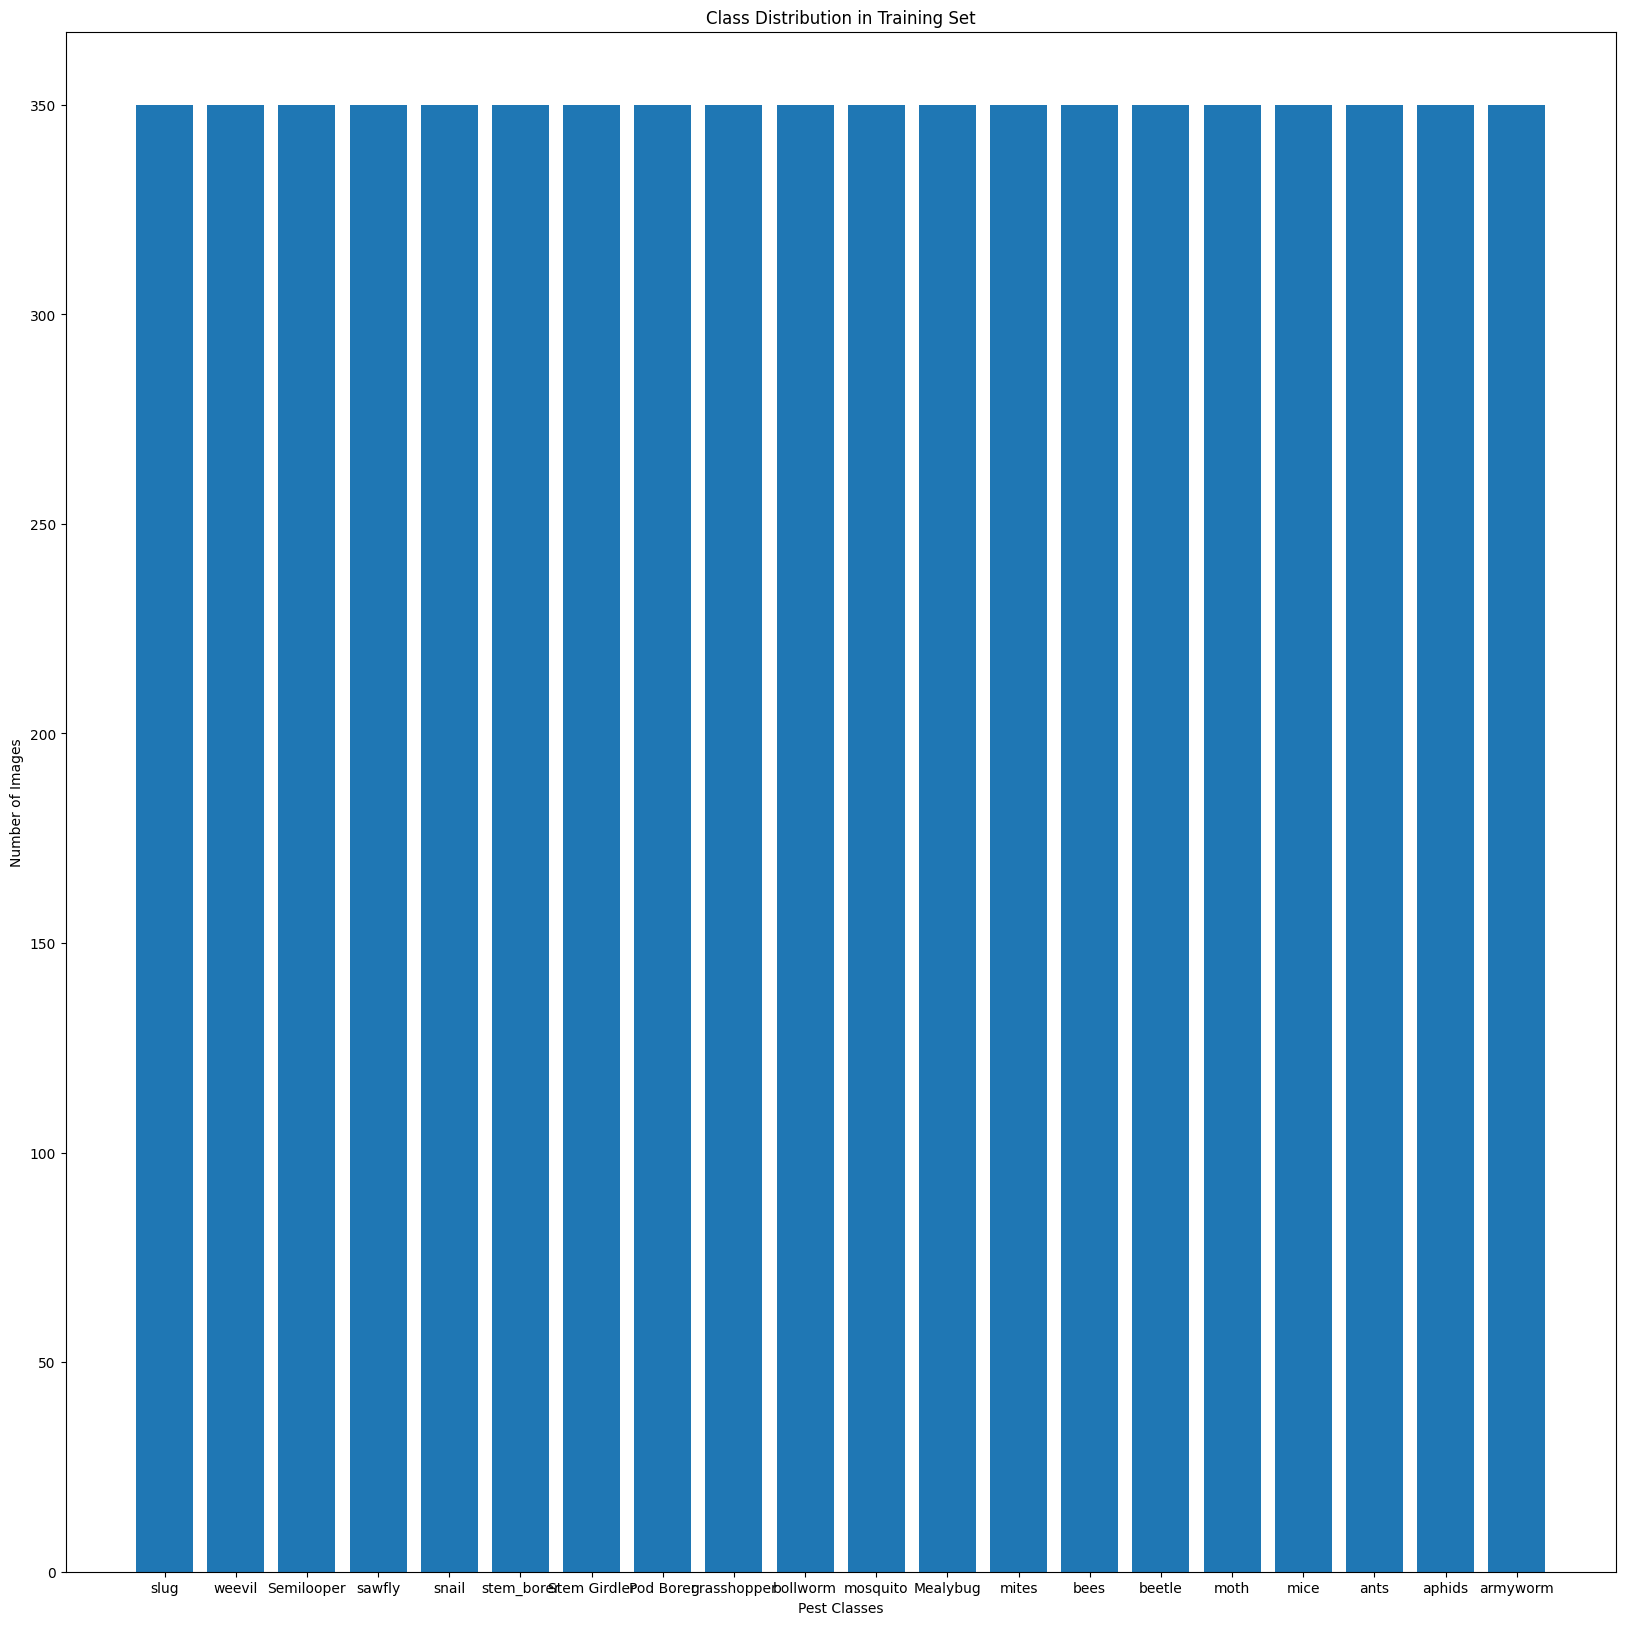

In [9]:
# Class Distribution
class_counts = {}
for class_name in train_class:
    train_class_dir = os.path.join(train_directory, class_name)
    class_counts[class_name] = len(os.listdir(train_class_dir))

plt.figure(figsize=(20, 20))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Pest Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.show()

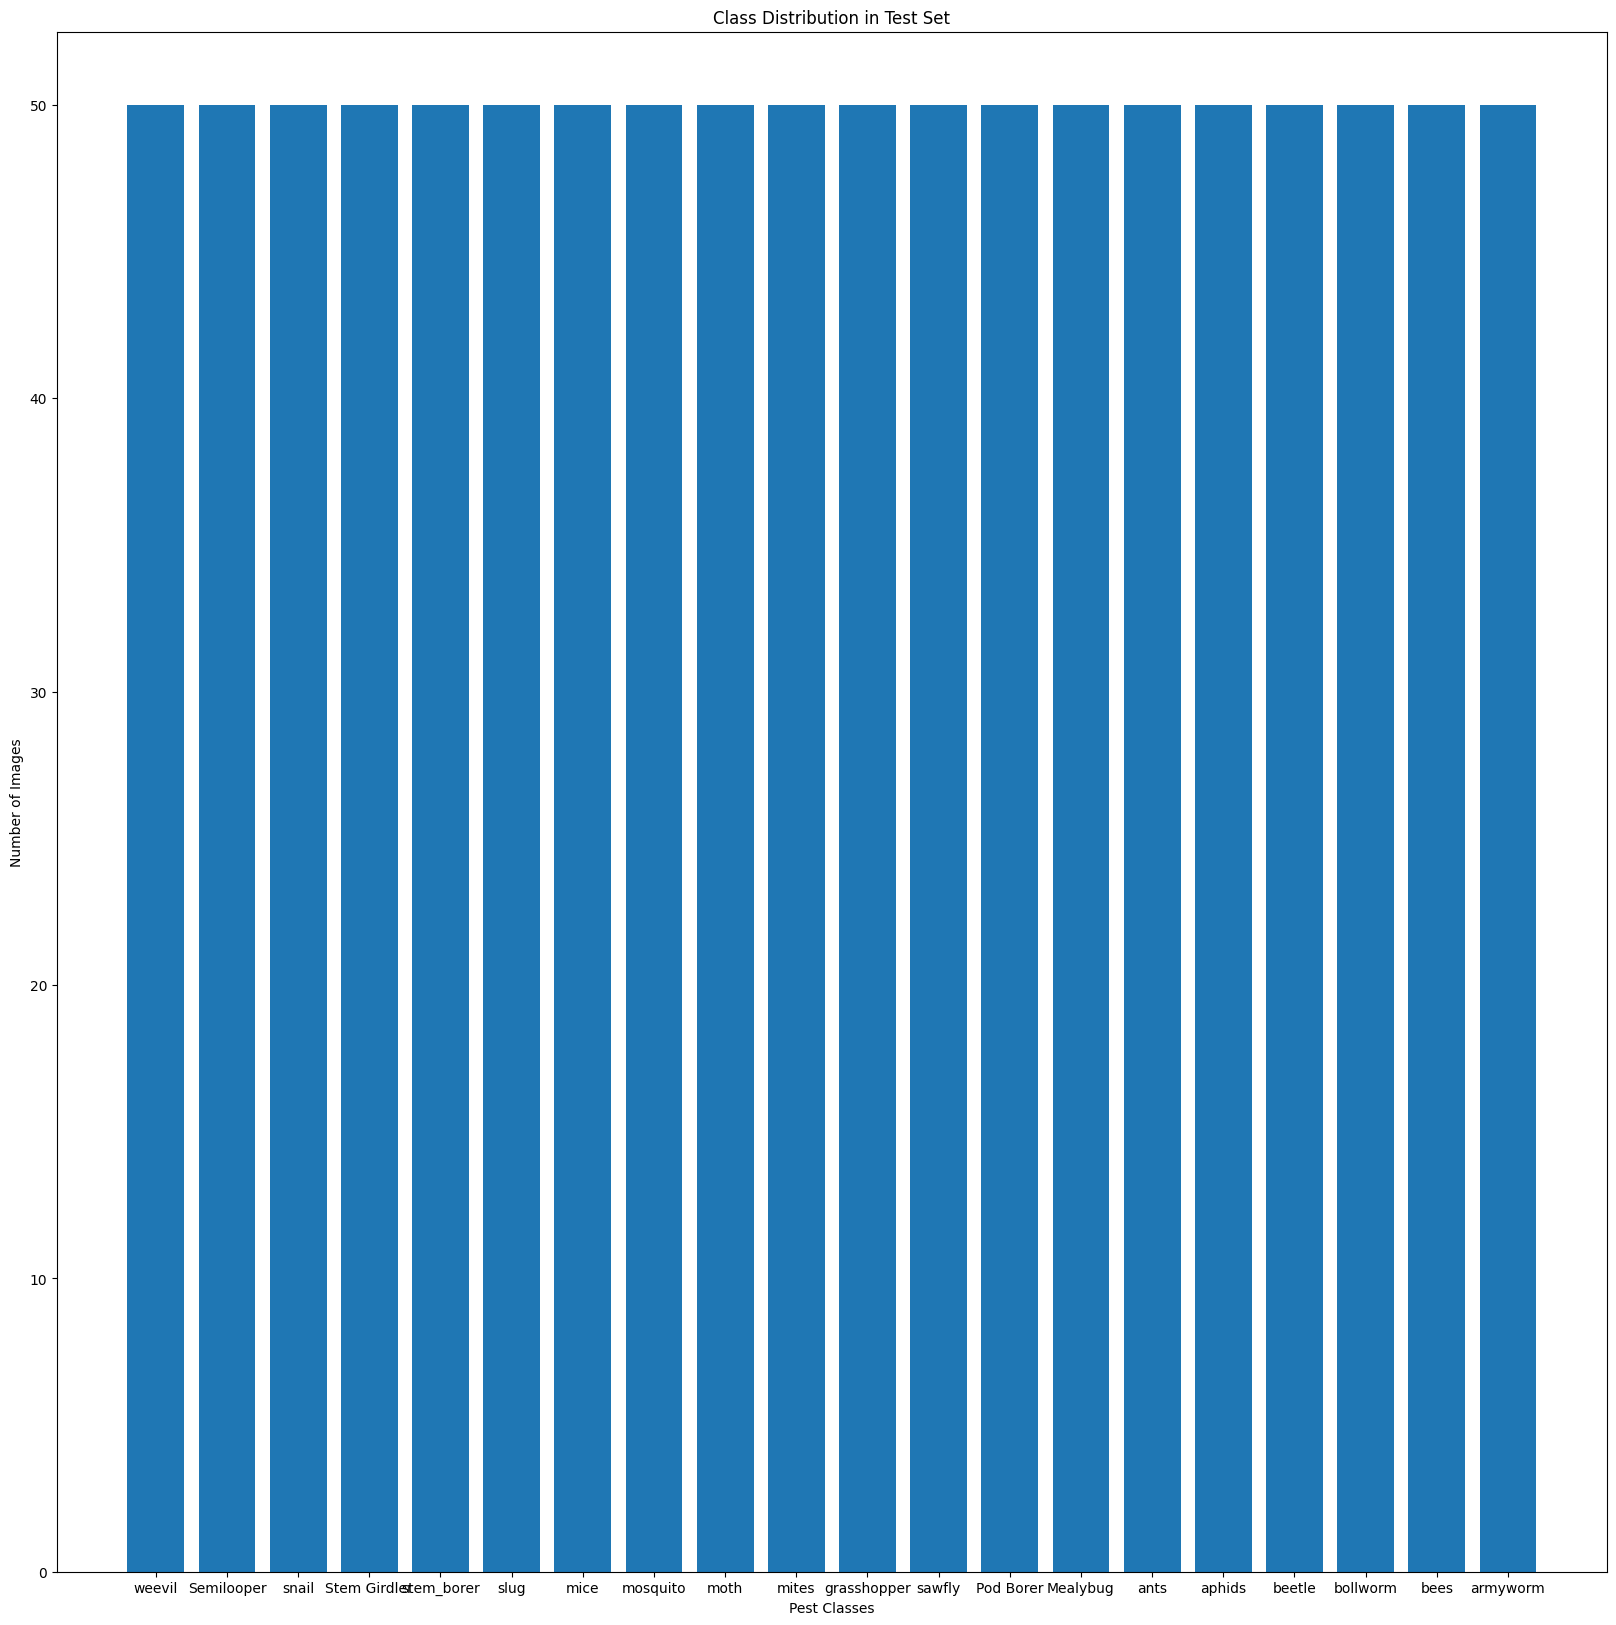

In [10]:
# Class Distribution
class_counts = {}
for class_name in test_class:
    test_class_dir = os.path.join(test_directory, class_name)
    class_counts[class_name] = len(os.listdir(test_class_dir))

plt.figure(figsize=(20, 20))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Pest Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Test Set")
plt.show()

**DATA PRE_PROCESSING AND MODEL**







In [11]:
#Data Agumenation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_generator = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(
    train_directory,
    batch_size=16,
    target_size=(224, 224),
    subset="training"
)


Found 6660 images belonging to 20 classes.


In [12]:
validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_directory,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

Found 340 images belonging to 20 classes.


In [13]:
testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_directory,batch_size=16,target_size=(224,224),shuffle=True)

Found 1000 images belonging to 20 classes.


**MODEL**


In [14]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))


In [15]:
# Define the base architecture of MobileNet
_base_architecture = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


In [16]:

# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)


In [17]:

# Define your model
model = Sequential([
    _base_architecture,
    MaxPooling2D(3, 2),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(20, activation='softmax')
])


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [34]:
pest_info ={
    "stem_borer": {
        "harmful": True,
        "pesticide": "Cypermethrin"
    },
    "mites": {
        "harmful": True,
        "pesticide": "Acaricide-X"
    },
    "ants": {
        "harmful": False,
        "pesticide": "Boric Acid"
    },
    "beetle": {
        "harmful": True,
        "pesticide": "Imidacloprid"
    },
    "aphids": {
        "harmful": True,
        "pesticide": "Neonicotinoid-Y"
    },
    "armyworm": {
        "harmful": True,
        "pesticide": "Spinosad"
    },
    "grasshopper": {
        "harmful": False,
        "pesticide": "Eco-Friendly Repellent"
    },
    "bollworm": {
        "harmful": True,
        "pesticide": "Bt toxin (Bacillus thuringiensis)"
    },
    "mosquito": {
        "harmful": False,
        "pesticide": "Larvicide-O"
    },
    "snail": {
        "harmful": False,
        "pesticide": "Metaldehyde"
    },
    "mices": {
        "harmful": False,
        "pesticide": "Rodenticide-Z"
    },
    "bees": {
        "harmful": False,
        "pesticide": "none"
    },
    "moth": {
        "harmful": False,
        "pesticide": "Bt toxin"
    },
    "weevil": {
        "harmful": True,
        "pesticide": "Organic Pyrethrin"
    },

    "semilooper": {
        "harmful": True,
        "pesticide": "Bacillus thuringiensis (Bt)"
    },
    "Stem Girdler": {
        "harmful": True,
        "pesticide": "neonicotinoids"
    },
    "Mealybug": {
        "harmful": True,
        "pesticide": " synthetic pyrethroids"
    },
    "Pod Borer": {
        "harmful": True,
        "pesticide": "Bacillus thuringiensis (Bt)"
    },

    "Sawfly": {
        "harmful": True,
        "pesticide": "Bacillus thuringiensis (Bt)"
    },
    "Slug": {
        "harmful": False,
        "pesticide": " synthetic pyrethroids"
    }
}


In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 1024)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                        

In [21]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-5)

history = model.fit(
    training_generator,
    epochs=10,
    validation_data=validing,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
417/417 [==============================] - 3947s 9s/step - loss: 1.6476 - accuracy: 0.5419 - val_loss: 3.2673 - val_accuracy: 0.1941 - lr: 0.0010
Epoch 2/10
417/417 [==============================] - 998s 2s/step - loss: 1.1053 - accuracy: 0.6680 - val_loss: 1.5587 - val_accuracy: 0.6235 - lr: 0.0010
Epoch 3/10
417/417 [==============================] - 1037s 2s/step - loss: 0.8297 - accuracy: 0.7498 - val_loss: 1.4926 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 4/10
417/417 [==============================] - 1041s 2s/step - loss: 0.7314 - accuracy: 0.7763 - val_loss: 1.0389 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 5/10
417/417 [==============================] - 1037s 2s/step - loss: 0.6498 - accuracy: 0.8017 - val_loss: 1.3555 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 6/10
417/417 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.8279
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
417/417 [==============================] - 

In [22]:
# prepare for fine-tuning
_base_architecture.trainable = True

In [24]:
# Fine-tune the model
fine_tune_epochs = 5
total_epochs = history.epoch[-1] + fine_tune_epochs + 1

history_fine = model.fit(training_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validing,
                         callbacks=[early_stopping,reduce_lr])



Epoch 10/15
417/417 [==============================] - 1077s 3s/step - loss: 0.0536 - accuracy: 0.9833 - val_loss: 0.4592 - val_accuracy: 0.8824 - lr: 4.0000e-05
Epoch 11/15
417/417 [==============================] - 1067s 3s/step - loss: 0.0520 - accuracy: 0.9833 - val_loss: 0.5172 - val_accuracy: 0.8588 - lr: 4.0000e-05
Epoch 12/15
417/417 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9853
Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-05.
417/417 [==============================] - 1061s 3s/step - loss: 0.0487 - accuracy: 0.9853 - val_loss: 0.5913 - val_accuracy: 0.8676 - lr: 4.0000e-05
Epoch 13/15
417/417 [==============================] - 1053s 3s/step - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.5635 - val_accuracy: 0.8529 - lr: 1.0000e-05
Epoch 13: early stopping


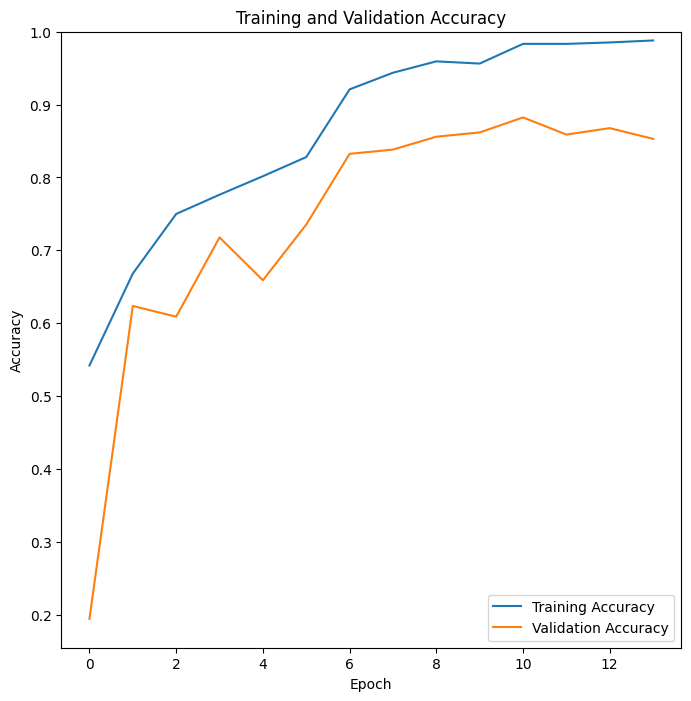

In [25]:
# Combine the training histories for accuracy
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']


# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [26]:
# Make predictions with the model
predictions = model.predict(testing)
predicted_classes = np.argmax(predictions, axis=1)

63/63 [==============================] - 619s 10s/step


In [27]:
# Get the True class labels
True_classes = testing.classes
class_labels = list(testing.class_indices.keys())

In [28]:
# Calculate the classification report
report = classification_report(True_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    Mealybug       0.00      0.00      0.00        50
   Pod Borer       0.10      0.08      0.09        50
  Semilooper       0.02      0.02      0.02        50
Stem Girdler       0.00      0.00      0.00        50
        ants       0.02      0.02      0.02        50
      aphids       0.04      0.04      0.04        50
    armyworm       0.04      0.04      0.04        50
        bees       0.07      0.06      0.06        50
      beetle       0.08      0.10      0.09        50
    bollworm       0.07      0.08      0.07        50
 grasshopper       0.06      0.06      0.06        50
        mice       0.11      0.10      0.11        50
       mites       0.06      0.06      0.06        50
    mosquito       0.09      0.10      0.10        50
        moth       0.04      0.04      0.04        50
      sawfly       0.04      0.04      0.04        50
        slug       0.05      0.04      0.05        50
       snail       0.03    

In [29]:

# Generate the confusion matrix
cm = confusion_matrix(True_classes, predicted_classes)


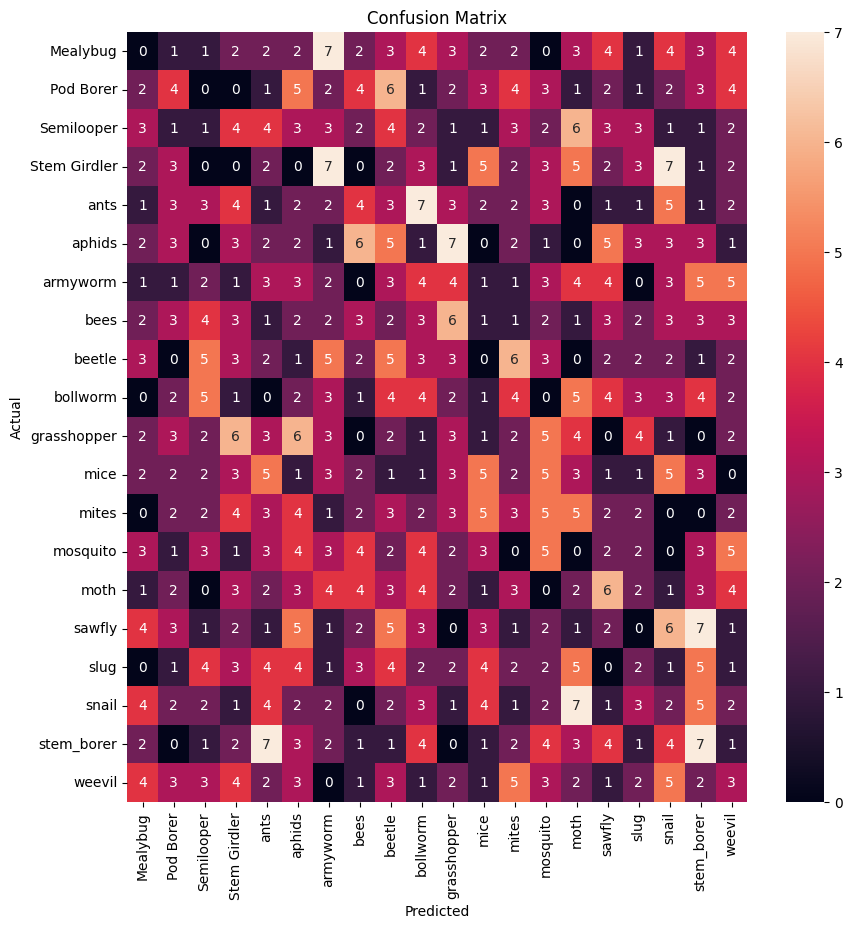

In [30]:
#Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

1/1 [==============================] - 1s 803ms/step


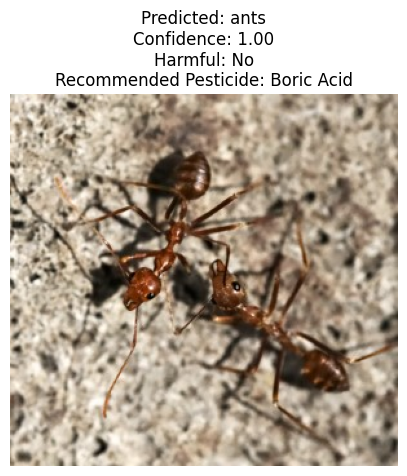

1/1 [==============================] - 0s 75ms/step


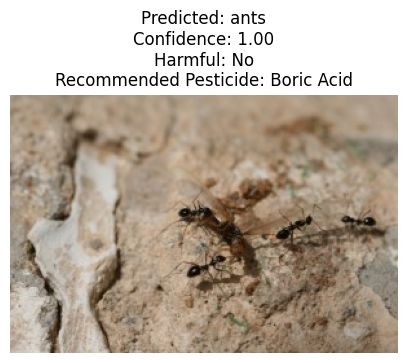

1/1 [==============================] - 0s 51ms/step


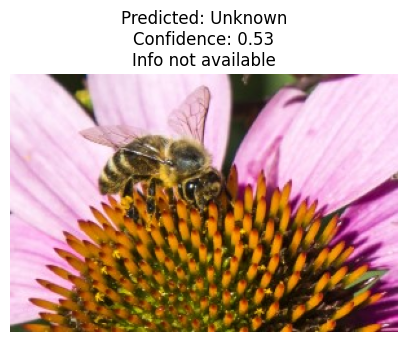

1/1 [==============================] - 0s 56ms/step


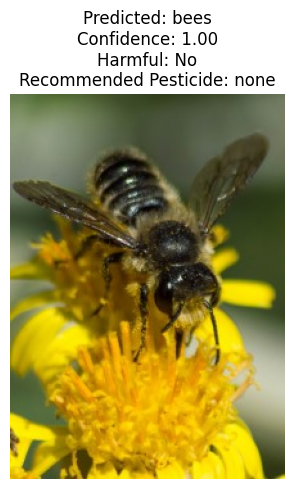

1/1 [==============================] - 0s 56ms/step


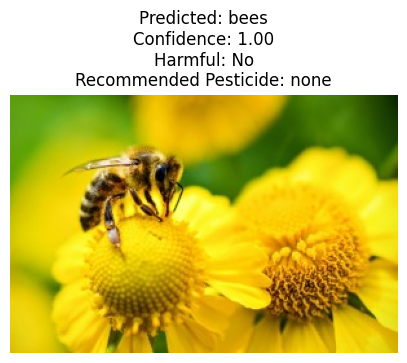

1/1 [==============================] - 0s 57ms/step


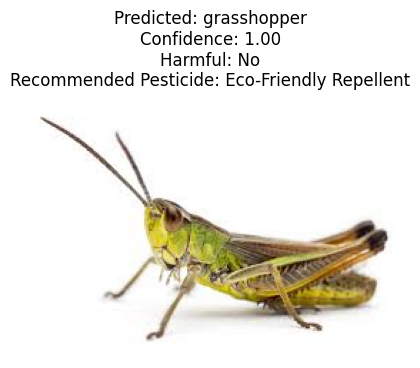

1/1 [==============================] - 0s 57ms/step


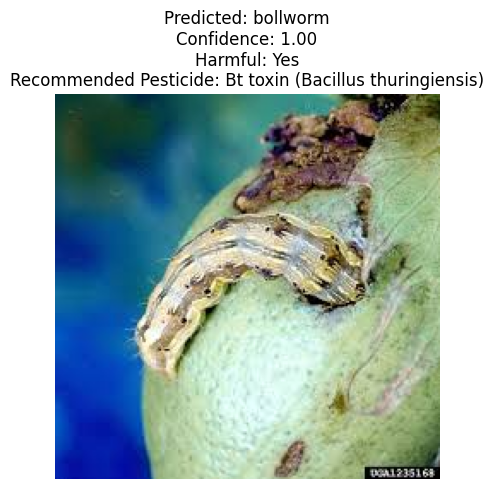

1/1 [==============================] - 0s 62ms/step


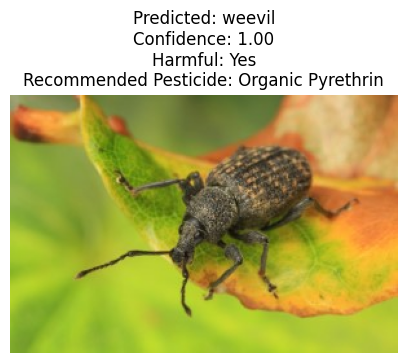

1/1 [==============================] - 0s 60ms/step


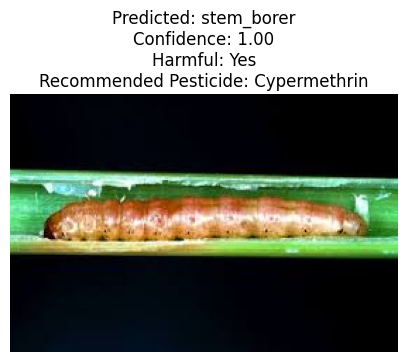

1/1 [==============================] - 0s 60ms/step


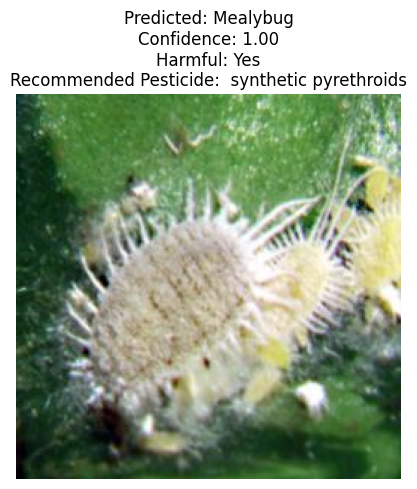

1/1 [==============================] - 0s 60ms/step


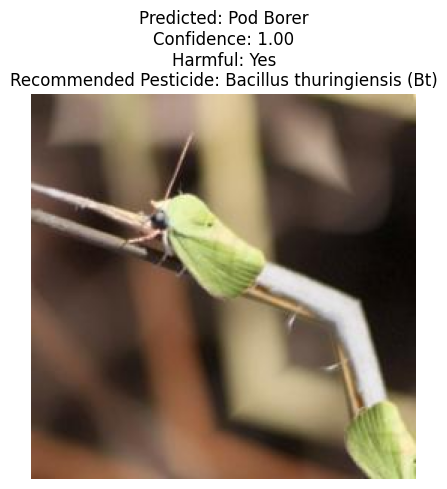

1/1 [==============================] - 0s 64ms/step


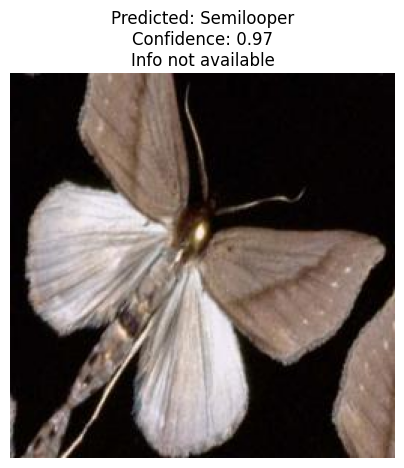

1/1 [==============================] - 0s 54ms/step


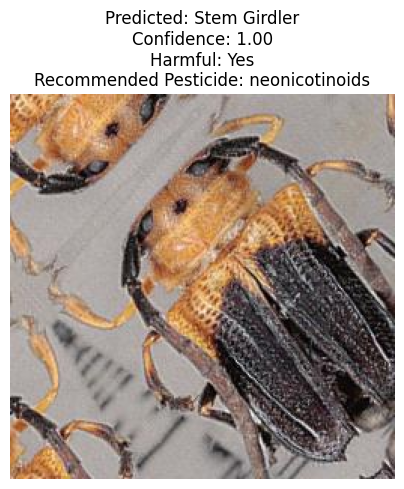

In [35]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def predict_image_class_with_confidence(model, img_path, target_size=(224, 224), confidence_threshold=0.65):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    confidence = np.max(predictions)
    predicted_class = np.argmax(predictions, axis=1)
    class_labels = list(training_generator.class_indices.keys())
    predicted_class_label = class_labels[predicted_class[0]]

    if confidence < confidence_threshold:
        return "Unknown", confidence
    else:
        return predicted_class_label, confidence

image_paths = [
          '/content/drive/MyDrive/Dataset/test/ants/ants (1).jpg',
          '/content/drive/MyDrive/Dataset/test/ants/ants (21).jpg',
          '/content/drive/MyDrive/Dataset/test/bees/bees (302).jpg',
          '/content/drive/MyDrive/Dataset/test/bees/bees (307).jpg',
          '/content/drive/MyDrive/Dataset/test/bees/bees (314).jpg',
          '/content/drive/MyDrive/Dataset/test/grasshopper/jpg_10.jpg',
            '/content/drive/MyDrive/Dataset/test/bollworm/jpg_18.jpg',
          '/content/drive/MyDrive/Dataset/test/weevil/Weevil (306).jpg',
          '/content/drive/MyDrive/Dataset/test/stem_borer/jpg_12.jpg',
          '/content/drive/MyDrive/4pestmy/Dataset/test/Mealybug/Mealybug (11).jpg',
         '/content/drive/MyDrive/4pestmy/Dataset/test/Pod Borer/podborer (10).jpg',
          '/content/drive/MyDrive/4pestmy/Dataset/test/Semilooper/Semilooper (10).jpg',
          '/content/drive/MyDrive/4pestmy/Dataset/test/Stem Girdler/Aug_Nupserha bicolor (Dutta)_10.jpg',







]

for img_path in image_paths:
    predicted_class_label, confidence = predict_image_class_with_confidence(model, img_path)
    img = image.load_img(img_path)

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

    if predicted_class_label != "Unknown" and predicted_class_label in pest_info:
        harmful = pest_info[predicted_class_label]['harmful']
        pesticide = pest_info[predicted_class_label]['pesticide']
        plt.title(f"Predicted: {predicted_class_label}\nConfidence: {confidence:.2f}\nHarmful: {'Yes' if harmful else 'No'}\nRecommended Pesticide: {pesticide}")
    elif predicted_class_label == "Unknown":
        plt.title(f"Predicted: Unknown\nConfidence: {confidence:.2f}\nInfo not available")
    else:
        plt.title(f"Predicted: {predicted_class_label}\nConfidence: {confidence:.2f}\nInfo not available")

    plt.show()

In [32]:
# Save the model
model.save('/content/drive/MyDrive/Model/New_Model1.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
import tensorflow as tf
import os

# Define the path where the original and the converted model will be saved
original_model_path = '/content/drive/MyDrive/Model/New_Model1.h5'
converted_model_path = '/content/drive/MyDrive/tflite/New_Model1.tflite'  # Use .tflite extension

# Load the Keras model
model = tf.keras.models.load_model(original_model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Check if the directory exists, if not, create it
model_directory = os.path.dirname(converted_model_path)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the converted model
with open(converted_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Converted model saved to: {converted_model_path}")


Converted model saved to: /content/drive/MyDrive/tflite/New_Model1.tflite
